#### Image classifier
Simple convolutional neural network for classifying images.


Author: Aleksandra Piekarzewicz

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.utils
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder

In [2]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# setting seeds
np.random.seed(300)
torch.manual_seed(300)
torch.use_deterministic_algorithms(True)

In [4]:
transform =  transforms.Compose([
            transforms.RandomHorizontalFlip(0.4),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            ])

final_transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            ])

In [5]:
all_data = ImageFolder('data/train/', transform=transform)
train_data, test_data = torch.utils.data.random_split(all_data, (round(0.8 * len(all_data.imgs)), round(0.2 * len(all_data.imgs))))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=8)

final_data = ImageFolder('data/test_all/', transform=final_transform)
final_test_loader = torch.utils.data.DataLoader(final_data, batch_size=128, shuffle=False, num_workers=8)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(40, 60, 5)
        self.pool2 = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(60 * 9 * 9, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.d2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(200, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.d1(F.relu(self.bn1(self.fc1(x))))
        x = self.d2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
epochs = 15

In [8]:
net.train()
for epoch in range(epochs):
    lr -= 0.00002

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1,  epochs, running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/15] loss: 0.818
[2/15] loss: 0.678
[3/15] loss: 0.631
[4/15] loss: 0.596
[5/15] loss: 0.573
[6/15] loss: 0.552
[7/15] loss: 0.535
[8/15] loss: 0.518
[9/15] loss: 0.502
[10/15] loss: 0.487
[11/15] loss: 0.475
[12/15] loss: 0.459
[13/15] loss: 0.448
[14/15] loss: 0.436
[15/15] loss: 0.425
Finished Training


In [9]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        #images = images.to(device)
        outputs = net(images).cpu()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 50 %


In [10]:
correct_pred = {classname: 0 for classname in all_data.classes}
total_pred = {classname: 0 for classname in all_data.classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        #images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[all_data.classes[label]] += 1
            total_pred[all_data.classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class acoustic is: 28.7 %
Accuracy for class antenna is: 48.6 %
Accuracy for class bacteria is: 48.0 %
Accuracy for class battery is: 50.6 %
Accuracy for class bean  is: 51.7 %
Accuracy for class beetle is: 63.6 %
Accuracy for class bicycle is: 63.7 %
Accuracy for class birch is: 40.9 %
Accuracy for class bird  is: 22.4 %
Accuracy for class bomb  is: 56.4 %
Accuracy for class bread is: 46.3 %
Accuracy for class bridge is: 64.7 %
Accuracy for class camera is: 63.8 %
Accuracy for class carbon is: 24.5 %
Accuracy for class cat   is: 43.7 %
Accuracy for class corn  is: 40.8 %
Accuracy for class crab  is: 22.4 %
Accuracy for class crocodilian is: 48.5 %
Accuracy for class echinoderm is: 40.1 %
Accuracy for class egg   is: 37.3 %
Accuracy for class elephant is: 66.2 %
Accuracy for class fish  is: 42.7 %
Accuracy for class flower is: 87.0 %
Accuracy for class frog  is: 39.6 %
Accuracy for class fungus is: 65.0 %
Accuracy for class gauge is: 53.0 %
Accuracy for class hammer is: 74

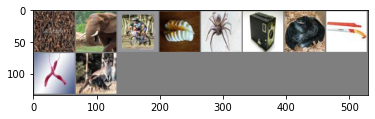

GroundTruth:  spice elephant bicycle   egg spider camera snake   saw bacteria kangaroo


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:10]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % all_data.classes[labels[j]] for j in range(10)))
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % all_data.classes[predicted[j]]
                              for j in range(10)))

Predicted:  spice elephant bicycle   egg spider camera carbon   saw hammer swine


In [13]:
state_dict = net.state_dict()
torch.save(state_dict, "model.tar")

In [14]:
names = []
for sample in final_data.samples:
    names.append(sample[0].split('\\')[-1])

In [15]:
predictions = []

for data in final_test_loader:
    images, labels = data
    #images = images.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.tolist()
    predictions += predicted

In [ ]:
import pandas as pd
all_preds = pd.DataFrame(data = {'col1': names, 'col2': predictions})
all_preds.to_csv("results.csv", header=None, index=False)